## Acoustic Signal Processing for Bioacoustics
### 07 - Introduction to Spatial Filtering

In this notebook, we introduce the concept of spatial filtering/beamforming with multiple microphones. We discuss some of the fundamental concepts of beamformers and show how a simple delay and sum beamformer works. There are many more advanced techniques of spatial filtering which we will not cover here, but I will provide some references for you to have a look at. 

Written by: Randall Ali (contact r.ali@surrey.ac.uk for questions/errors/suggestions!)

In [7]:
import numpy as np 
import scipy as sp
from scipy import signal
import sounddevice as sd
import soundfile as sf
from matplotlib import pyplot as plt
from ipywidgets import * # interactive plots
import IPython
from IPython.display import Audio, Image
%matplotlib ipympl



### Introduction

When multiple microphones are used for monitoring the acoustic environment, the **spatial information** encoded in each microphone signal will be different due to the different acoustic propagation paths from the source of interest (say a bird call for instance) to all of the microphones as well as the different microphone responses. By exploiting this spatial information, the multiple microphone signals can be modified and combined so as to achieve a maximum response in particular directions and minimum in others.  For instance, in an acoustic scenario consisting of multiple noise sources and one target source of interest, the spatial information encoded in multiple sensors within that acoustic field can be manipulated in order to attenuate the interfering noises and maintain the target source. 

In the frequency domain, this is done by applying a linear time-invariant filter, i.e. a complex-valued weighting to each of the sensor signals and then summing the resulting output. (Note that in considering the frequency domain here, we are making the assumption that the observation interval of our signal is infinite, whereas in practice shorter snapshots/segments of a signal is observed in which case a formulation in the short-time Fourier transform domain should be considered. The principle of spatial filtering nevertheless remain the same).

The two features that determine the performance of such spatial filters is their geometry and the design of the complex weightings. Typical geometric configurations may consist of sensors in a linear array, a circular array, a spherical array, a planar array, or even randomly distributed. Each configuration has particular advantages and disadvantages and may be more suited depending on the application at hand. In the remaining of this notebook, however, the concept of spatial filtering in the frequency domain is introduced by analysing the beam pattern for a linear array of microphones.


### The signal model

The first thing we need to do is decide on an appropriate signal model for the recorded microphone signals. Let's consider a scenario where we have a linear array consisting of $M$ microphones. For a single source, we can model the $m^{th}$ ($m \in [1,2, \dots, \mathrm{M}]$) microphone signal in the discrete-time domain ($n$ being the sample index) as:

\begin{equation}
\large
\mathrm{y}_{m}[n] = \sum_{i=0}^{L_{a}} \mathrm{a}_{m}[i] \mathrm{s}[n-i] + \mathrm{v}_{m}[n]
\end{equation}

where $\mathrm{a}_{m}$ is the impulse response of length (in samples) $L_{a}$ from the source, $s$, to the $m^{th}$ microphone, $\mathrm{y}_{m}[n]$, and $\mathrm{v}_{m}$ is a noise signal. The first term on the right-hand side of the equation is a discrete-time convolution between the impulse response and the source. The impulse response represents the acoustic propagation from the source to the $m^{th}$ microphone and can consist of reflections/scattering from the ground and other objects such as trees. It will also be influenced by environmental conditions such as temperature, humidity, etc. the We can extend this model to include multiple sources by including another summation, however, for simplicity in this notebook, we will stick to one source.

In the frequency domain, we can express the discrete-time convolution as a multiplication (recall that we are considering an infinite observation signal, however this will also hold for time frames of an STFT where the length of a time frame is sufficiently longer than $L_{a}$) , and hence the signal model becomes 
\begin{equation}
\large
\mathrm{y}_{m}(\omega) = \mathrm{a}_{m}(\omega) \mathrm{s}(\omega) + \mathrm{v}_{m}(\omega).
\end{equation}
where $\omega = 2 \pi f$ is the angular frequency (rad/s) and $f$ is the frequency (Hz).

We can stack all the microphone signals in a vector and write the signal model as follows

\begin{equation}
\begin{bmatrix}
\mathrm{{y}_{1}}(\omega) \\ 
\mathrm{{y}_{2}}(\omega) \\
\vdots \\
\mathrm{{y}_{M}}(\omega)
\end{bmatrix}
= 
\begin{bmatrix}
\mathrm{{a}_{1}}(\omega) \\ 
\mathrm{{a}_{2}}(\omega) \\
\vdots \\
\mathrm{{a}_{M}}(\omega)
\end{bmatrix} s(\omega) + \begin{bmatrix}
\mathrm{{n}_{1}}(\omega) \\ 
\mathrm{{n}_{2}}(\omega) \\
\vdots \\
\mathrm{{n}_{M}}(\omega)
\end{bmatrix}\nonumber
\end{equation}

or simply as (where the bold notation is used to represent the vector):
\begin{equation}
\mathbf{y}(\omega) = \mathbf{a}(\omega) s(\omega) + \mathbf{v}(\omega)
\end{equation}


### Spatial Filtering

The spatial filtering process involves applying a complex weighting to each of the elements in $\mathbf{y}(\omega)$ and summing the output, i.e. performing the following inner product
\begin{align}
\hat{s}(\omega) &= \mathbf{w}^{\mathit{H}}(\omega)\mathbf{y}(\omega) \\
                &= \mathbf{w}^{\mathit{H}}(\omega)\mathbf{a}(\omega) s(\omega) + \mathbf{w}^{\mathit{H}}(\omega)\mathbf{v}(\omega)
\end{align}
where $\{.\}^{\mathit{H}}$ denotes the [conjugate transpose](https://mathworld.wolfram.com/HermitianMatrix.html), and $\mathbf{w}(\omega) = {[\mathrm{w}_{1}(\omega)\hspace{0.1cm}\mathrm{w}_{2}(\omega)\hspace{0.1cm} \dots \mathrm{w}_{M}(\omega)]}^{T}$ is a vector of the complex weightings, commonly referred to as a **beamformer**. From our signal model, we can see that the spatial filtering will result in a "spatially-filtered" source component and a "spatially-filtered" noise component. If our goal is to retrieve the source, then ideally we would like the source component to be undistorted, i.e., $\mathbf{w}^{\mathit{H}}(\omega)\mathbf{a}(\omega) = 1$ and the noise component to be a minimum, i.e., we would like that $ \mathbf{w}^{\mathit{H}}(\omega)\mathbf{v}(\omega) \rightarrow 0$. As a reminder, recall that the result of the above equation gives a scalar complex value for each frequency, from which an inverse Fourier transform can be applied to get back the signal in the discrete-time domain. 





### The far field assumption

Recall that when we record microphone signals, all we have access to is $\mathbf{y}(\omega)$, i.e. our observed signals, but $\mathbf{a}(\omega)$, $s(\omega)$, and $\mathbf{v}(\omega)$ are unknown. In order to begin to do some sort of spatial processing, we need to make some modelling decisions on  $\mathbf{a}(\omega)$ and $\mathbf{v}(\omega)$ in particular. For instance it can be assumed that the noise in each microphone of $\mathbf{v}(\omega)$ is uncorrelated so that $\mathbb{E}\{\mathbf{v}(\omega) \mathbf{v}^{\mathit{H}}(\omega) \} = \sigma^{2} \mathbf{I}$, i.e., the expected value of the outer product is a scaled identity matrix with a noise power spectral density, $\sigma^{2}$. 

For this notebook, we will focus on the model for $\mathbf{a}(\omega)$. In conventional array processing, sources are considered to be in the **far field**, i.e. they are much further in comparison to the distances that separate the microphones. In such a case, an added convenience is that we can treat the wave propagation as that of plane waves. For omnidirectional microphones, the amplitudes among the various microphones will be similar, and the differences are then only due to the phase shifts resulting from the time delay of propagation among the different microphones. Furthermore, under the far field conditions, when the positions of the source and microphones are expressed in spherical coordinates, we can describe the acoustic scenario in terms of angles of incidence in relation to the microphones. In order to develop this notion further, the specific microphone arrangement of a uniformly spaced linear array by $d$ metres is considered as in Fig. 1.

<br>
<br>

<div>
<center> <img src="img/ULA.png" width="350"/> <center/>
    <p style="text-align:center">Fig. 1 - Uniformly spaced linear microphone array with a target source in the far field. </p>
</div>

<br>
<br>


With such an arrangement, since the source is in the far field, it can be perceived as impinging from some angle, $\theta$ in relation to the axis common to all microphones. Denoting the first microphone as the uppermost microphone in Fig. 1, it can be observed that the additional distance that the plane waves travel to each successive microphone is simply a factor of $d \cos \theta$. Hence the time delay, $\tau_{m}$ associated with the $m^{th}$ microphone for $m \in [1,2, \dots, \mathrm{M}]$ can be parametrized as a function of the angle $\theta$ as follows:

\begin{equation}
\tau_{m}(\theta) = \frac{(m-1) d \cos \theta}{c}
\end{equation}

With this far field assumption, we can model $\mathbf{a}(\omega)$ as a function of $\theta$ as well

\begin{align}
\large
\mathbf{a}(\omega, \theta)=  \begin{bmatrix}
	1 \\
	e^{-j\frac{\omega d \cos \theta}{c}} \\
	\vdots \\
	e^{-j\frac{\omega (M-1) d \cos \theta}{c}} 
	\end{bmatrix}
\end{align}

where ${\mathbf{a}}(\omega, \theta)$ is commonly referred to as a relative **steering vector** among all of the microphones in relation to the first ($m=1$). It is simply a vector of phase shifts as a result of the time delays, $\tau_m(\theta)$, for $m \in [1,2, \dots, \mathrm{M}]$. 



### Spatial Response

With the far field model, let us revisit the spatial filtering process. Now the source estimate will be given as:
\begin{align}
\hat{s}(\omega) &= \mathbf{w}^{\mathit{H}}(\omega)\mathbf{y}(\omega) \\
                &= \underbrace{\mathbf{w}^{\mathit{H}}(\omega)\mathbf{a}(\omega, \theta)}_{\text{spatial response}, \Psi(\omega, \theta)} s(\omega) + \mathbf{w}^{\mathit{H}}(\omega)\mathbf{v}(\omega)
\end{align}

where we denote the spatial response as \Psi(\omega, \theta). This is also referred to as the **beam pattern** and taking its magnitude gives us the associated **directivity pattern** for the microphone array. By adjusting the complex-valued weights, $\mathbf{w} (\omega)$, various beam patterns can be designed and optimised accordingly to some desired criterion. 


### Delay and Sum Beamformer

Perhaps the most conventional beamformer to use as an example to illustrate the directivity patterns is that of a delay-and-sum (DAS) beamformer. As its name implies, time delays are introduced to each microphone in order to compensate for the delays experienced by each microphone as previously discussed, in relation to Fig. 1. This results in a coherent alignment of the source signal, which is then summed and averaged across all microphones. Such time delays can be introduced as equivalent phase shifts in $\mathbf{w}(\omega)$, which are derived as function of the incident source angle, and hence can be used to steer the microphone array to ``look" at a particular direction. The DAS beamformer can be formulated as:

\begin{align}
\mathbf{w}_{\mathrm{DAS}}(\omega)=  \frac{1}{M}\begin{bmatrix}
1 \\
e^{-j\frac{\omega d \cos \theta_o}{c}} \\
\vdots \\
e^{-j\frac{\omega (M-1) d \cos \theta_o}{c}} 
\end{bmatrix}
\end{align}
where $\theta_o$ is the desired angle to which the array is to be steered. Substitution of this equation into the above equation for $\hat{s}$ results in:

\begin{align}
\large
\hat{s}(\omega) &= \mathbf{w}_{DAS}^{\mathit{H}}(\omega)\mathbf{y}(\omega) \\
                &=  \frac{1}{M} \left( \mathrm{y_{1}}(\omega) + e^{j\frac{\omega d \cos \theta_o}{c}}  \mathrm{y_{2}(\omega)} + \dots + e^{j\frac{\omega (M-1) d \cos \theta_o}{c}}  \mathrm{y_{M}(\omega)} \right)
\end{align}

which explicity shows that a phase shift is being applied to each microphone signal (corresponding to a time delay of  $((m-1) d \cos \theta_o)/c$ for the $m^{th}$ microphone), which is then summed and averaged by the total number of microphone signals, $M$. 

Let's have a look at this and see how that works.


Listen to the first microphone signal


Move the slider to see the effect of steering the delay and sum beamformer to different angles:


interactive(children=(IntSlider(value=90, description='theta_o', max=180), Output()), _dom_classes=('widget-in…

<function __main__.update(theta_o=90)>

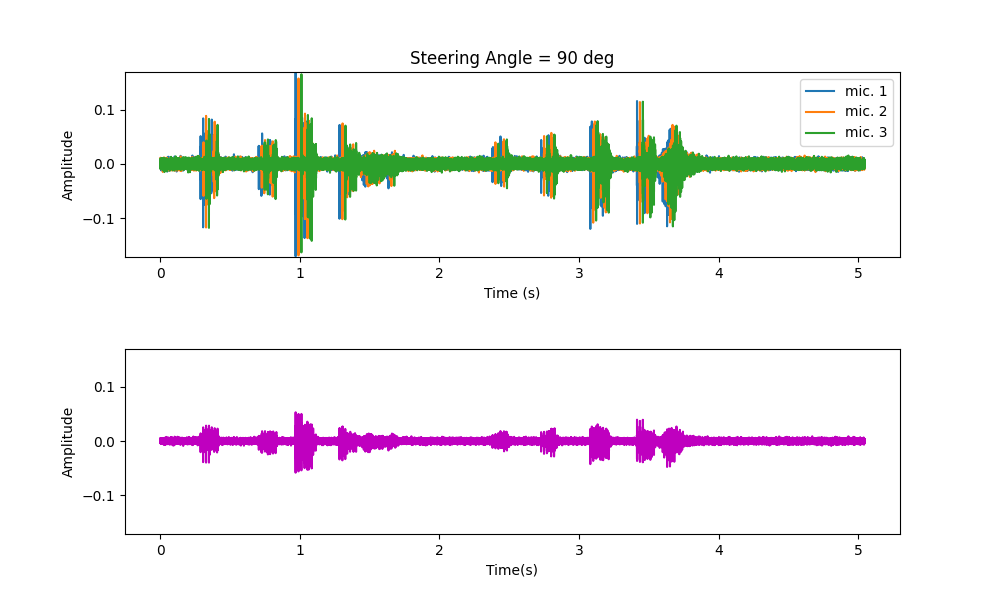

In [22]:
# DAS beamformer. Although we have explain the concept in the frequency domain, we will show the result in the time domain.

# function for obtaining the delays
def get_delays(M, d, theta, fs):
    
    # M - number of microphones
    # d - intermicrophone spacing (m)
    # theta - steering angle (degrees)
    # fs - sampling frequency

    delays = np.zeros(M) # will give the delays in terms of samples for each mic.
    theta_rad = (np.pi/180)*theta # angle in radians
    c = 340 # speed of sound (m/s)
    
    for m in range(M):
        delays[m] = np.round((((m)*d*np.cos(theta_rad))/c)*fs) # multiply by fs to get in terms of samples and round to get an integer
        
    return delays

# Read in the signal
[y_raw,fs] = sf.read('./audio/Wes_cap.wav') # Read in your audio file
y = y_raw # Extract a section
y = y - np.mean(y) # Removing the mean of the signal
N = len(y)
del y_raw

# Zero padding the signal - this is simply because we are using a circular shift later on 
y1 = np.zeros([N+2000]) 
y1[0:N] = y # zero padded original signal

tt = np.arange(0,len(y1),1)*(1/fs) # time vector

# Parameters
M = 3        # 3 microphone scenario (assuming a linear array)
d = 10       # microphone spacing (m). Each mic. spaced by the same amount. Using a large spacing to exaggerate.
theta_o = 45  # The direction from which the signal is coming from (degrees)
delays_o = get_delays(M=M, d=d, theta=theta_o, fs=fs) 

# Get the other two mic. signals - "simulating" the mic. signals as if they were coming from the direction theta_o
y2 = np.roll(y1,delays_o[1])
y3 = np.roll(y1,delays_o[2])

# Add uncorrelated white noise to each of the mics
noise = 0.004*np.random.randn(len(y1),M) # generating uncorrelated white noise
y1 = y1 + noise[:,0]
y2 = y2 + noise[:,1]
y3 = y3 + noise[:,2]


# Listen
print('Listen to the first microphone signal')
IPython.display.display(Audio(y1.T, rate=fs, normalize=False))

fig, axes = plt.subplots(2,1,figsize=(10, 6))
fig.subplots_adjust(hspace=0.5)

axes[0].plot(tt,y1, label='mic. 1')
line2, = axes[0].plot(tt,y2, label='mic. 2')
line3, = axes[0].plot(tt,y3, label='mic. 3')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_ylim([np.min(y1)-0.001, np.max(y1)+0.001])
axes[0].legend()

linesum, = axes[1].plot(tt, (1/M)*(y1+y2+y3), color='m')
axes[1].set_xlabel('Time(s)')
axes[1].set_ylabel('Amplitude')
# axes[1].set_xlim([lags[0], lags[-1]])
axes[1].set_ylim([np.min(y1)-0.001, np.max(y1)+0.001])



def update(theta_o = 90):

    delays_steer = get_delays(M=M, d=d, theta=theta_o, fs=fs) # getting the different delays for the different angles

    # Apply the delays to the different signals
    y2_steered = np.roll(y2,-delays_steer[1])
    y3_steered = np.roll(y3,-delays_steer[2])

    # Sum up the signals
    y_sum = (1/M)*(y1+y2_steered+y3_steered)

    # Update the plots
    line2.set_ydata(y2_steered)
    line3.set_ydata(y3_steered)
    linesum.set_ydata(y_sum)
    
    axes[0].set_title('Steering Angle = ' + str(theta_o)+' deg')

    print('Listen to the spatially filtered signal')
    IPython.display.display(Audio(y_sum.T, rate=fs,normalize=False))
    
print('Move the slider to see the effect of steering the delay and sum beamformer to different angles:')
interact(update, theta_o = (0,180,1))

### Spatial Response of the DAS beamformer

Looking to the spatial response or directivity pattern of the DAS beamformer, we find that

\Large
\begin{align}
\Psi(\omega, \theta) &=  \mathbf{w}_{DAS}^{\mathit{H}}(\omega)\mathbf{a}(\omega, \theta) \\
                    &= \frac{1}{M} \sum_{m=0}^{M-1} e^{-j\omega\frac{ m d (\cos \theta - \cos \theta_o)}{c}}
\end{align}

Hence we can observe that the directivity pattern of the microphone array for a DAS array is:

1. Number of microphones (M)
2. Inter-microphone spacing (d)
3. Frequency at which beamforming is done ($f$ in $\omega = 2\pi f$) (which is related to the wavelength)
4. Angle to which the beam is being steered to ($\theta_o$)

Let's have a look at the impact of these parameters on the directivity patterns.

Move the slider to see how the parameters change the cosine and listen to the result


interactive(children=(FloatSlider(value=0.1, description='d', max=1.0, min=0.1), IntSlider(value=1500, descrip…

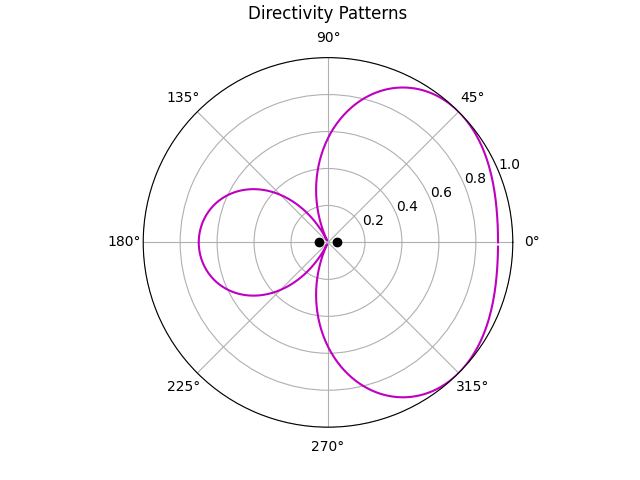

In [23]:
# Working all in polar coordinates.
    
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

dirline, = ax.plot([], [],'m')
micline, = ax.plot([], [],'ko')
ax.set_rmax(1)
# ax.set_yticklabels([])
ax.grid(True)

ax.set_title("Directivity Patterns", va='bottom')


def update(d = 0.1, freq=1500, theta_o_deg=45, M=2):

    mic_pos = np.zeros((M,2))
    for m in range( (M//2) ):
        mic_pos[m] = np.array([np.pi , (m+1)*d/2 ]) # mic. position (theta, r)
        mic_pos[m + M//2] = np.array([0 , (m+1)*d/2 ]) # mic. position (theta, r)
    
    
    theta_o = (np.pi/180)*theta_o_deg
    omega = 2*np.pi*freq
    c = 343

    steering_vector = np.zeros(M,dtype = 'complex')
    for m in range( M ):
        steering_vector[m] =  np.exp(1j*omega*m*(d*np.cos(theta_o))/c)
        
    lam = 343/freq
    print('Wavelength:', lam)
    print('d/Wavelength:', d/lam)
    
    angles = np.arange(0,2*np.pi,np.pi/128) # range of angles to evaluate BP
    DirPat = np.zeros(len(angles))
    
    for n in np.arange(0, len(angles),1):
        array_manifold = np.zeros(M,dtype = 'complex')
        for m in range( M ):
            array_manifold[m] = np.exp(-1j*omega*m*(d*np.cos(angles[n]))/c)
        DirPat[n] = (1/M)*np.abs(array_manifold@steering_vector)

    
    micline.set_data(mic_pos[:,0], mic_pos[:,1])
    dirline.set_data(angles, DirPat)
        


print('Move the slider to see how the parameters change the cosine and listen to the result')
interact(update, d = (0.1,1,0.1), freq=(20,4000,100), theta_o_deg=(0,360,15), M=(2,10,2)); 


### Some obeservations: spatial aliasing and ambiguities

As can be seen the directivity patterns vary quite significantly depending on the aformentioned parameters. To make a few structural observations, let's firstly recall that the wavelength, $\lambda$, of a wave is related to its frequency by

\begin{equation}
\lambda = \frac{c}{f} 
\end{equation}


Several important aspects of the directivity patterns can be explained by considering how $d$ varies with respect to $\lambda$.

1. For $d << \lambda$ or $\frac{d}{\lambda} << 1$ the directivity pattern is quite omnidirectional. This is because for such long wavelengths, the phase differences, and hence the time delays, in the plane wave from any incident angle among the microphones is quite small. Consequently, there is not much steering that can be done and the array acts as an omnidirectional receiver.

2. As the ratio $\frac{d}{\lambda}$ increases, the beam pattern becomes more directional. We can also see that when the steering angle is not $0^{o}$ or $180^{o}$, a symmetric beam appears. So for instance, if the steering angle is $60^{o}$, we see a beam at $60^{o}$ and $300^{o}$. As far as the linear array is concerned, it observes the same phase difference from both of these positions, and hence cannot distinguish any difference. This is a **spatial ambiguity** and is primarily due to the symmetry of the array.

3. When $\frac{d}{\lambda} > \frac{1}{2}$, the wavelength becomes small in comparison to the microphone spacing, and hence the same phase difference can be observed from a number of spatial positions, resulting in multiple beams that are produced, commonly referred to as
grating lobes. This is what is referred to as **spatial aliasing**, i.e. the spatial equivalent of aliasing to time domain aliasing. The criterion under which spatial aliasing can be avoided is when $\frac{d}{\lambda} < \frac{1}{2}$.

4. We can also see that the beam widths become narrower in general as the number of microphones increase.


### References

We have only really scratched the surface here with the concept of spatial filtering. There has been quite a bit of research into this area and there are more approaches where the acoustic transfer functions  and noise statistics are for instance estimated from data. I'll leave those concepts for another time, but will leave you with a few references in case you want to read more into those approaches. 

1. R.Ali, Multi-microphone Speech Enhancement: An Integration of A Priori and Data-dependent Spatial Information (Ch. 2), Ph.D. thesis, KU Leuven, 2020. https://theses.eurasip.org/theses/881/multi-microphone-speech-enhancement-an/ (I am including my thesis here as Chapter 2, specifically 2.7.1 gives a concise summary of how much of this works and there are many references which I point to.)

2. H. L. V. Trees, Optimum Array Processing. John Wiley and Sons, Ltd, 2002.

3. Markovich-Golan, S., Kellermann, W. and Gannot, S. (2018). Spatial Filtering. In Audio Source Separation and Speech Enhancement (eds E. Vincent, T. Virtanen and S. Gannot). https://doi.org/10.1002/9781119279860.ch10
